In [33]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy.stats import norm


## Simulating discrete random variables

Suppose we want to generate a random variable $X$ such that

\begin{equation}
 X = \left\{ \begin{array}{cl}
                 a & \mbox{with prob. p}\\
                 b & \mbox{with prob. 1-p}
                 \end{array}\right. ,
\end{equation}
                 
but you only have a uniform random number generator. What can you do?

Note that a uniform random number over $[0,1]$, $U$, satisfies
\begin{eqnarray}
U &\le& p  \mbox{ with prob. p}\\
U &>& 1-p  \mbox{ with prob. 1-p}
\end{eqnarray}

Hence we can generate $X$ as follows:
\begin{equation}
 X = \left\{ \begin{array}{cl}
                 a & \mbox{if } U\le p\\
                 b & \mbox{if } U > 1-p
                 \end{array}\right.
\end{equation}

This property is used e.g. in simulating Markov chains and in the acceptance-rejection step in the Metropolis-Hastings algorithm.



In [95]:
p = 0.7
a = 10
b = 100
n = 10000
U_data = np.random.rand(n) # uniform random number generator

X_data = np.empty_like(U_data)
X_data[U_data<=0.7] = a
X_data[U_data>0.7] = b

print('True expected value', p*a+(1-p)*b)
print('Simulated average', X_data.sum()/n)

True expected value 37.0
Simulated average 37.324


Everytime you run the above cell, new random variables U's are drawn and the simulation result changes. 

To avoid this, you need to use np.random.seed(). (I will later use this.)

By changing $n$ and by running the above cell for a number of times, you will see that the variance of the simulated mean is not small unless you use sufficiently large $n$. This is common for a Monte Carlo integration.


We can generalize this to a situation where $X$ can take many (but finite) values:

$$ X = x_i \mbox{ with prob. } p_i, $$

for all $i=1,...,n$ with $\sum_{i=1}^n p_i = 1$.

Then, 

$$ U \in [0, p_1) \mbox{ with prob. } p_1$$

and

$$ U \in [\sum_{j=1}^{i-1} p_j, \sum_{j=1}^i p_j) \mbox{ with prob. } p_i.$$

## Simulating a univariate continuous random variable

One can simulate a univariate continuous random variable, again using a uniform random variable.

The idea here is that a cumulative distribution function (cdf) has the range between $[0,1]$, hence

$$ Prob[X<x] = cdf(x) = Prob[U<cdf(x)] = Prob[cdf^{-1}(U)<x].$$

This is clearly a generalization of the above discrete r.v. case. 

Therefore if we draw a uniform random variable $U$ and set

$$ X = cdf^{-1}(U), $$

then the cumulative distribution function of $X$ is given by cdf.

For this approach to be useful, a cdf must be easily invertible. 

Scipy has many statistical functions and you do not need to invert CDF yourself to generate random variables.

See <https://docs.scipy.org/doc/scipy/reference/stats.html> for the list of functions.

The following cell reviews some important methods using the beta distribution.

<https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html>

In [151]:
# Beta distribution
from scipy.stats import beta

a,b = 1.5, 2.8 # two parameters

# generate random numbers
x = beta.rvs(a, b, size=1000) 

# alternatively, we may write
y = beta(a,b).rvs(1000) 

# compute moments. 'mvsk' means mean, variance, skewness, and kurtosis
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk') 

# evaluate pdf at 0.3

z = beta(a,b).pdf(0.3)

## Simulating a Markov chain

An $n$-state Markov chain consists of 
1. A state vector, $[x^1,x^2,...,x^n]$, 
2. Initial distribution vector $q_0 = [q_1,...,q_n]$ and
2. The transition probabilities, $p_{ij} = \mbox{Probability of moving from state $i$ to state $j$}$, for all $i$ and $j$.

The transition probabilities are succinctly summarized by the transition matrix $P$, whose $(i,j)$-element is $p_{ij}$. We restrict our attention here to the time-homogeneous case where $P$ is independent of time elapsed.

We can simulate a Markov chain as follows:

**Step 1**: draw the initial state $x_i$ randomly from the initial distribution.

**Step 2**: Given a current state $x_k$, draw the next state $x_{k+1}$ using a uniform random variable $U$ as 

$$ x_{k+1} = x^1 \mbox{ if } U \in [0, p_{k1})$$

and

$$ x_{k+1} = x^i \mbox{ if } U \in [\sum_{j=1}^{i-1} p_j, \sum_{j=1}^i p_j).$$

**Step 3**: Increase $k$ by 1 and go back to Step 2 until $k$ reaches a pre-specified number $K<\infty$.


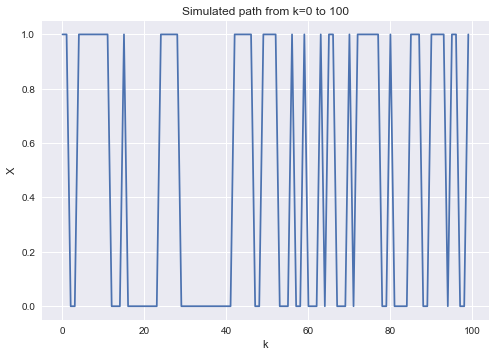

In [140]:
# A two-state Markov chain example

n = 2
X = [0., 1.]
q0 = [0.2, 0.8]
P = np.array([[0.8, 0.2],
              [0.4, 0.6]])


K = 10000 # simulation length

# arrays to store simulation data
i_data = np.zeros(K, dtype='int')
x_data = np.zeros(K)


# initial draw

if np.random.rand() <= q0[0]:
    i_data[0] = 0
else:
    i_data[0] = 1  

x_data[0] = X[i_data[0]]
    
for k in range(1,K):
    if np.random.rand() <= P[i_data[k-1],0]:
        i_data[k] = 0
    else:
        i_data[k] = 1  
    x_data[k] = X[i_data[k]]


fig, ax = plt.subplots()
line = plt.plot(x_data[0:100])
ax.set(xlabel='k', ylabel='X', title='Simulated path from k=0 to 100')
plt.show()


### Stationary distribution

A vector $q$ is said to be a stationary distribution of a Markov chain if

$$ q = P^T q.$$

I.e. if the current distribution of $X$ is given by $q$, the next period distribution of $X$ is also $q$. Stationary here means time-invariant.

Because $P$ is a probability matrix, the existence of a stationary distribution is guaranteed. 

There can be multiple stationary distributions, and if there are, then there is a continuum of stationary distributions; $q_1 = P^T q_1$ and $q_2 = P^T q_2$ imply that any convex combination of $q_1$ and $q_2$ is a stationary distribution. 

If $p_{ij}>0$ for all $i,j$, then the stationary distribution is unique. The stationary distribution can be obtained by either finding the eigenvector that is associated with the eigenvalue of one or iterating

$$ (P^T)^k q_0 $$

until it converges.


In [141]:
# Computing a stationary distribution via iteration

max_iter = 500

q_st = np.reshape(np.array(q0), (n,1))

i_iter = 0
while i_iter<=max_iter:
    i_iter += 1
    q_st = P.T@q_st

print('Stationary distribution vector (transposed)', q_st.T)
print('P^T*q_st (transposed)', (P.T@q_st).T)


Stationary distribution vector (transposed) [[ 0.66666667  0.33333333]]
P^T*q_st (transposed) [[ 0.66666667  0.33333333]]


Convergence to the stationary distribution implies that, in the long-run, the (unconditional) distribution of simulated data is effectively the same as the stationary distribution.

This is confirmed in the above example:

In [142]:
print('Frequency of state 1 = ', 1-i_data[500:].sum()/(K-500), ' Prob. of state 1 = ', q_st[0,0])
print('Frequency of state 2 = ', i_data[500:].sum()/(K-500), ' Prob. of state 2 = ', q_st[1,0])


Frequency of state 1 =  0.677368421053  Prob. of state 1 =  0.666666666667
Frequency of state 2 =  0.322631578947  Prob. of state 2 =  0.333333333333


What this suggests is that, in order to sample from a distribution, one may instead simulate a Markov chain whose stationary distribution is identical to that distribution. This is the very idea underlying the Markov chain Monte Carlo methods.


## Metropolis-Hastings algorithm

In Bayesian statistics, we are interested in the posterior distribution:

$$ posterior(\theta|x) = \frac{p(x|\theta)prior(\theta)}{\int p(x|\theta^*)prior(\theta^*)d\theta^*}. $$

If we use so-called conjugate priors, then the posteriors belong to the same family (by definition) and we can characterize the posterior easily. But in general we want to set priors more flexibly.

When a posterior does not have an analytical expression, you may consider characterizing it by sampling from it. The biggest challenge here is to evaluate the denominator of the right hand side. E.g. $\theta$ may be high-dimensional. Even when $\theta$ is low-dimensional and you approximate the denominator somehow, in order to sample from a posterior, you need to invert its CDF, and that's even harder.

The Markov chain Monte Carlo methods instead construct a Markov chain such that its stationary distribution coincides with the posterior.

In this lecture we focus on the Metropolis-Hastings algorithm, as it is easy to implement.

### Algorithm

1. Fix $\theta_0$, a conditional probability distribution $g(\theta'|\theta)$, and $f(\theta)$ that is proportional to $p(x|\theta)prior(\theta)$.
2. For $k=1,2,...$, 
    1. Generate a proposal $\theta' \sim g(\theta'| \theta_{k-1})$.
    2. [Acceptance-rejection step] Compute $$ \alpha(\theta'|\theta_{k-1}) := \min\{1, \frac{f(\theta')g(\theta_{k-1}|\theta')}{f(\theta_{k-1})g(\theta'|\theta_{k-1})}\}$$
    3. Set $\theta_k = \theta'$ with probability $\alpha(\theta'|\theta_{k-1})$ and $\theta_k=\theta_{k-1}$ with the remaining probability.

In any Metropolis algorithm, $g$ is symmetric in that $g(\theta'|\theta)=g(\theta|\theta')$, which implies that the accceptance probability $\alpha$ is

$$ \alpha(\theta'|\theta_{k-1}) := \min\{1, \frac{f(x|\theta')}{f(x|\theta_{k-1})}\}.$$

The acceptance probability is one if $p(x|\theta)prior(\theta)$ improves by moving from $\theta_{k-1}$ to $\theta'$. Otherwise, the acceptance probability is less than one.


### Example

The example and the code below are taken from <http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/>.

As an example, we consider a relatively simple model:

the prior is

$$ \theta \sim N(0,1) $$

and the model is 

$$ x|\theta \sim N(\theta,1).$$

The choice of $g(\theta'|\theta)$ is the normal density with mean $\theta$ and a fixed variance. The proposal is hence

$$ \theta' = \theta +\epsilon, \quad \epsilon \sim N(0,\sigma_\epsilon^2).$$

This is called the Random-Walk MH algorithm.


The likelihood of $\theta$ given data $x$ is given by

$$ p(x|\theta) = \prod_i pdf^{Normal}(x_i|mean=\theta,variance=1).$$

This is computed by executing $\texttt{norm(mean, scale).pdf(data).prod()}$.



In [160]:
np.random.seed(123) # Fix the seed so that the draws below do not change.

mu_true = 0.0

data = np.random.randn(20) + mu_true # artificial data

mu_prior_mu, mu_prior_sd = 0., 1.

propose_sigma = 0.5 

mu_current = 1. # initial value

samples = 15000

posterior = [mu_current]
for i in range(samples):
    mu_proposal = norm(loc=mu_current, scale=propose_sigma).rvs()  # Random-Walk

    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    
    # Compute prior probability of current and proposed mu        
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)


    # Numerator of Bayes formula
    p_current = likelihood_current * prior_current
    p_proposal = likelihood_proposal * prior_proposal

    p_accept = p_proposal / p_current

    accept = np.random.rand() < p_accept

    if accept:
        # Update position
        mu_current = mu_proposal

    posterior.append(mu_current)    

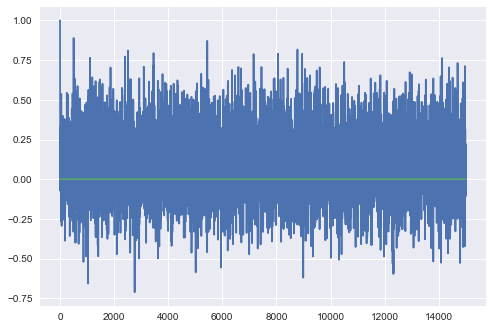

In [161]:
fig, ax = plt.subplots()
line = plt.plot( range(samples+1), posterior)
line2 = plt.plot( range(samples+1), mu_true*np.ones_like(posterior) )
plt.show()

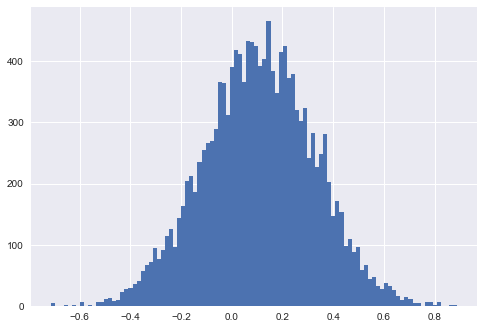

In [162]:
plt.hist(posterior[500:],100)
plt.show()

What is good about this example is that we can actually obtain the posterior analytically. This is an example of a conjugate prior.

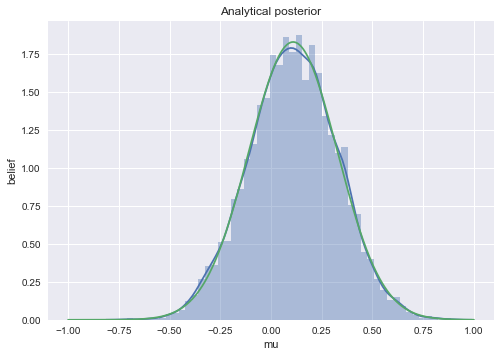

In [163]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

import seaborn as sns

ax = plt.subplot()
sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-1, 1, 500)+mu_true
posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd )
line1 = ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
plt.show()

The distribution of draws is close to the true posterior, as you can see.

## Quiz

1. Prove that if $p_{ij}>0$ for all $i,j$, then the stationary distribution of a Markov chain is unique.
2. Using scipy.stats.norm(), generate normally distributed random variables with mean = 0.5, variance = 5, and sample size = 100. Plot the histogram and the true density function. What happens if you use a larger sample size? Hint: see <https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html> 
3. The above code for the Markov chain simulation example is specific to the two-state case. Describe IN WORDS what you need to modify in order to simulate a general $n$-state Markov chain. You don't need to implement it.
4. The Metropolis-Hastings algorithm part allows for the true mean to be different from zero. Change mu_true to see the result for such a case.
